# 1 Ramp 1x1x3

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

In [2]:
import os


output_dir = 'plots_interval'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:

file_paths = {
    'deactivated': 'logs/1ramp_1x3/deactivated_log.csv',
    'alinea': 'logs/1ramp_1x3/alinea_log.csv',
    'MultPerGreen': 'logs/1ramp_1x3/MultPerGreen_log.csv',
    'OnePerGreen': 'logs/1ramp_1x3/OnePerGreen_log.csv',
    'pi-alinea': 'logs/1ramp_1x3/pi-alinea_log.csv'
}


features_all = ['Upstream Flow', 'Downstream Flow', 'Bottleneck Occupancy', 'Downstream Occupancy', 'Queue Length']


features_alinea = ['Upstream Flow', 'Downstream Flow', 'Bottleneck Occupancy', 'Downstream Occupancy', 'Queue Length', 'Metering Rate', 'Green Time', 'Red Time']

In [ ]:

def time_from_step(step, max_step, total_simulation_time=3*3600, start_time_hour=6):
    """
    Converts step number to a time string (HH:MM) representing simulation time.
    Assumes 0 to total_simulation_time (seconds) corresponds to the entire simulation.
    """
    time_in_seconds = (step / max_step) * total_simulation_time
    hours = int(time_in_seconds // 3600) + start_time_hour
    minutes = int((time_in_seconds % 3600) // 60)
    return f"{hours:02}:{minutes:02}"

In [ ]:

data = {}
max_step = 0  
for strategy, path in file_paths.items():
    try:
        data[strategy] = pd.read_csv(path)
        max_step = max(max_step, data[strategy]['Step'].max())
    except FileNotFoundError:
        print(f"Error: File not found for strategy {strategy}")
        data[strategy] = None

# time labels using the maximum step
time_labels = [time_from_step(step, max_step) for step in range(0, max_step + 1, 100)] # Reduced label density for better readability

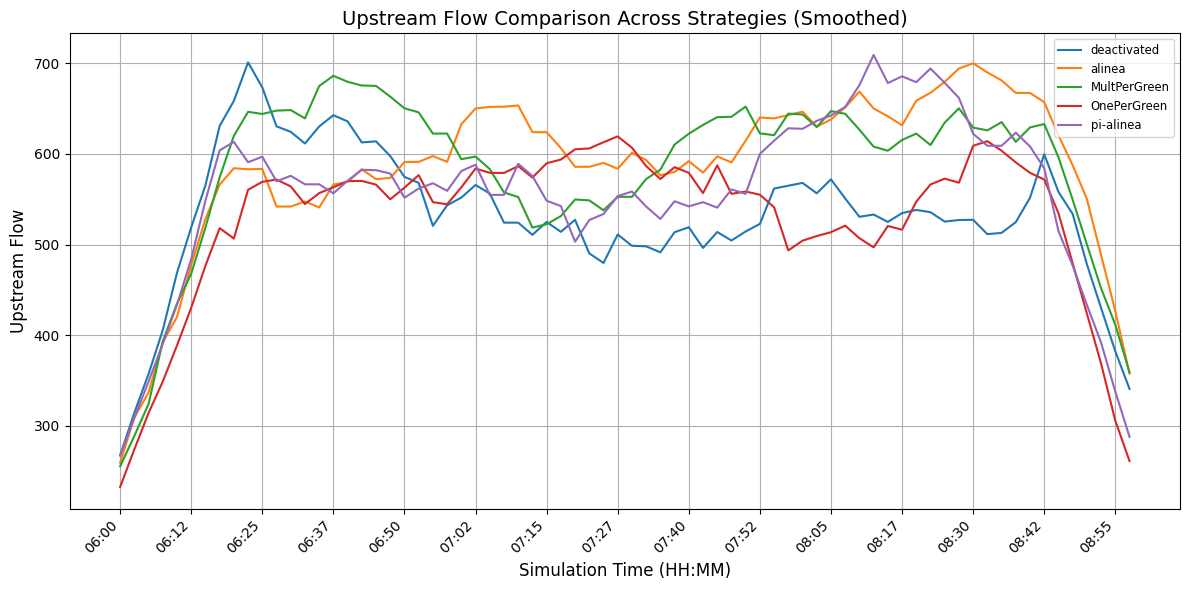

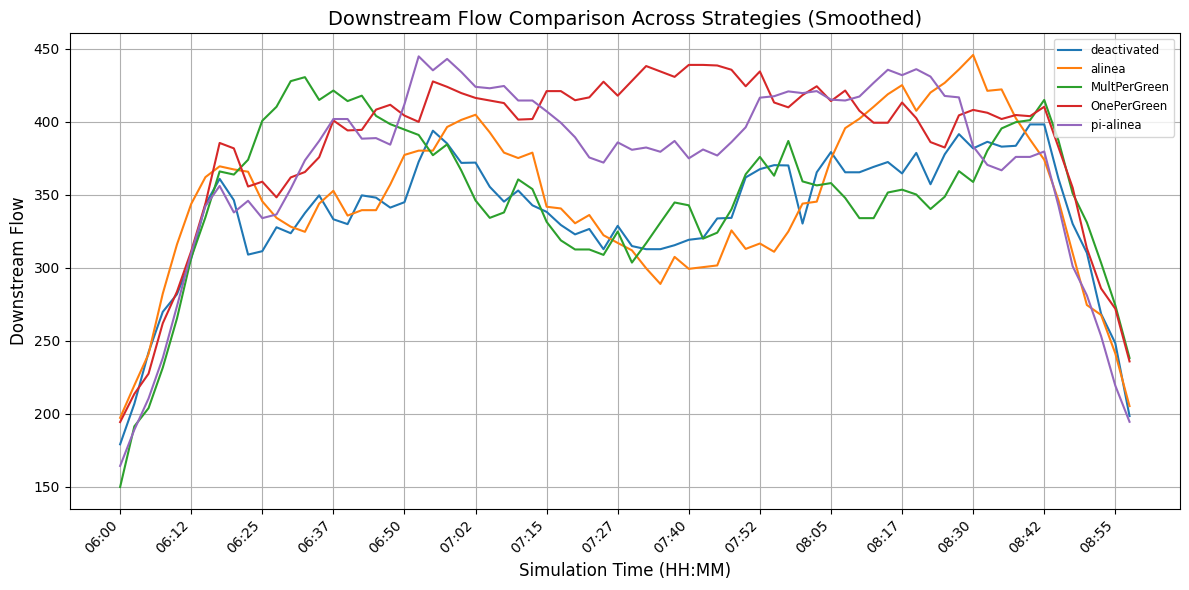

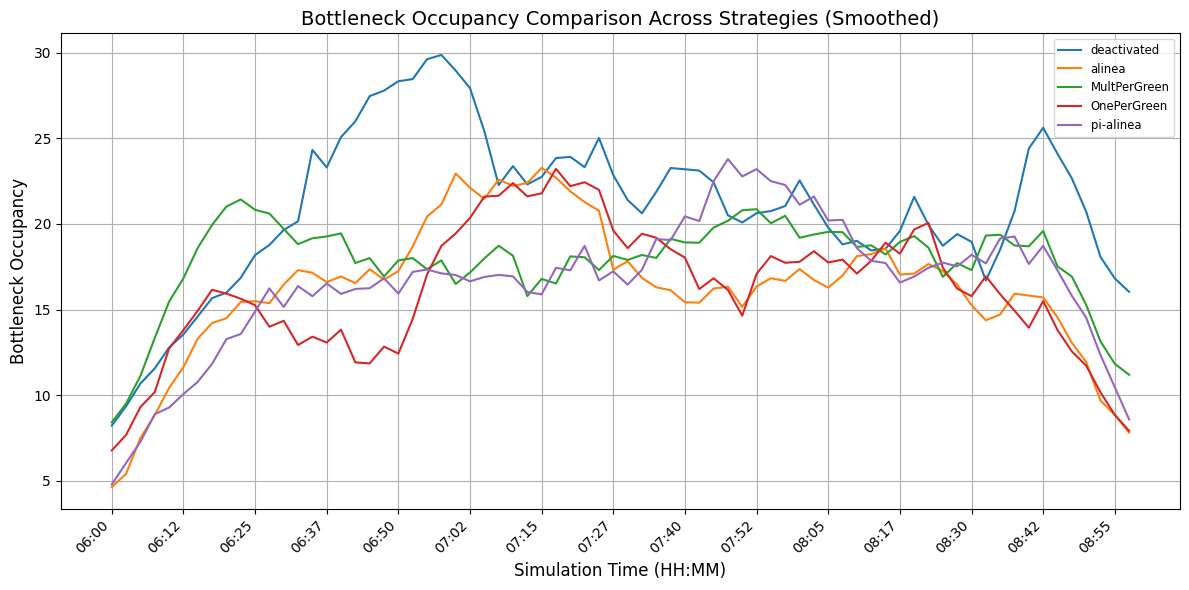

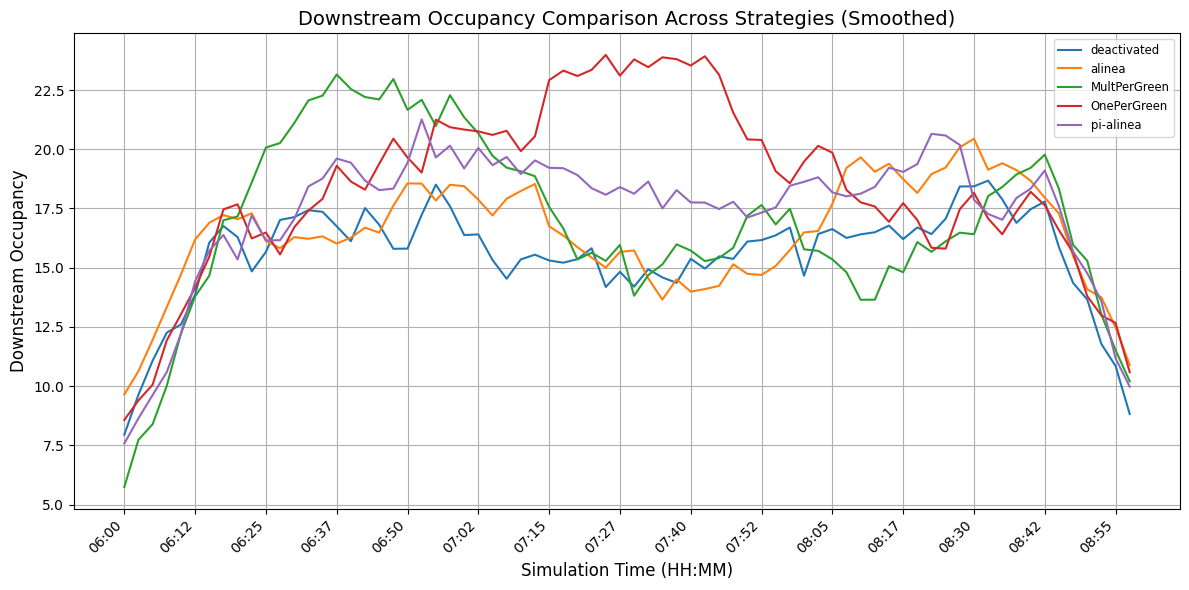

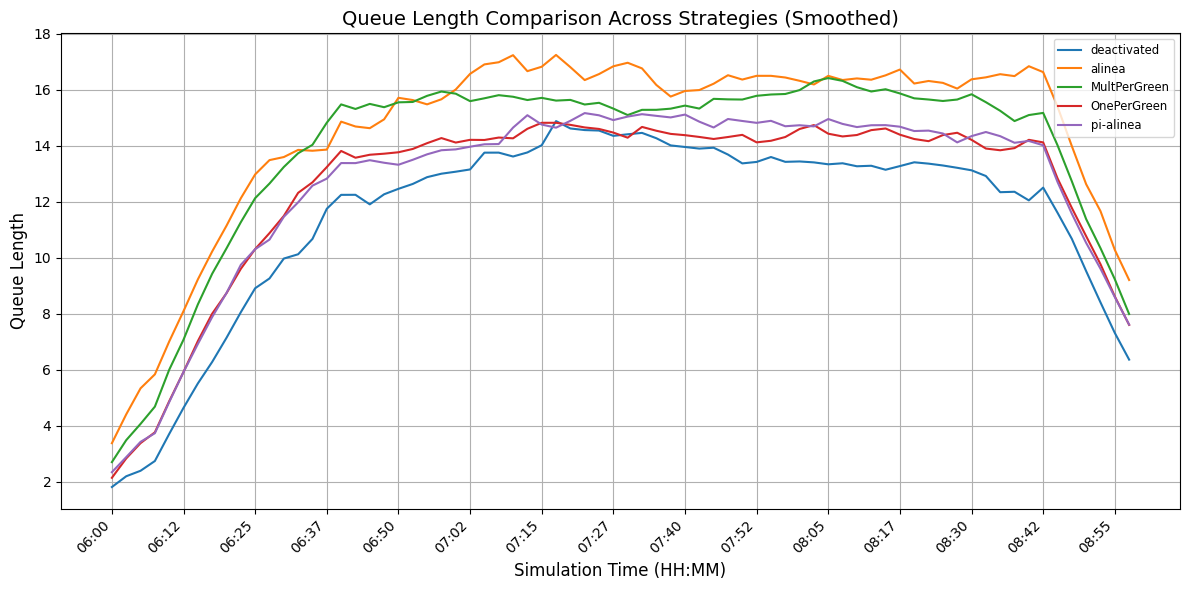

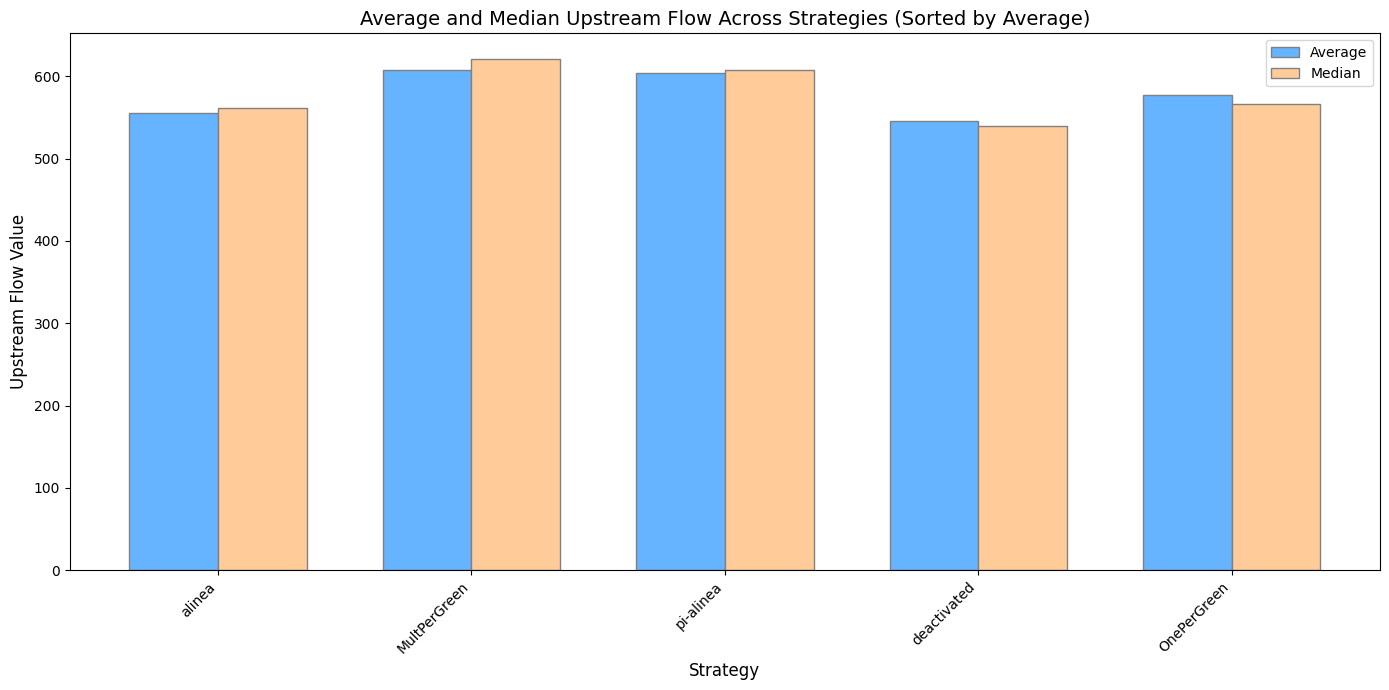

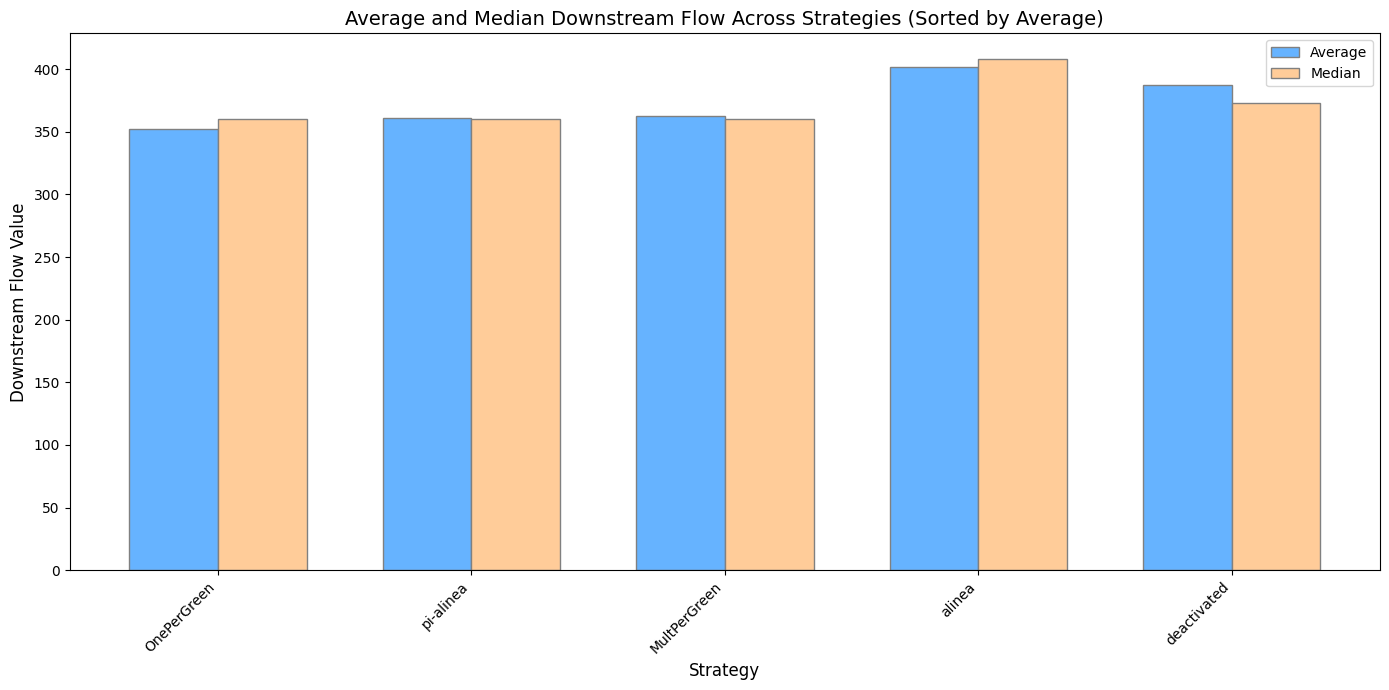

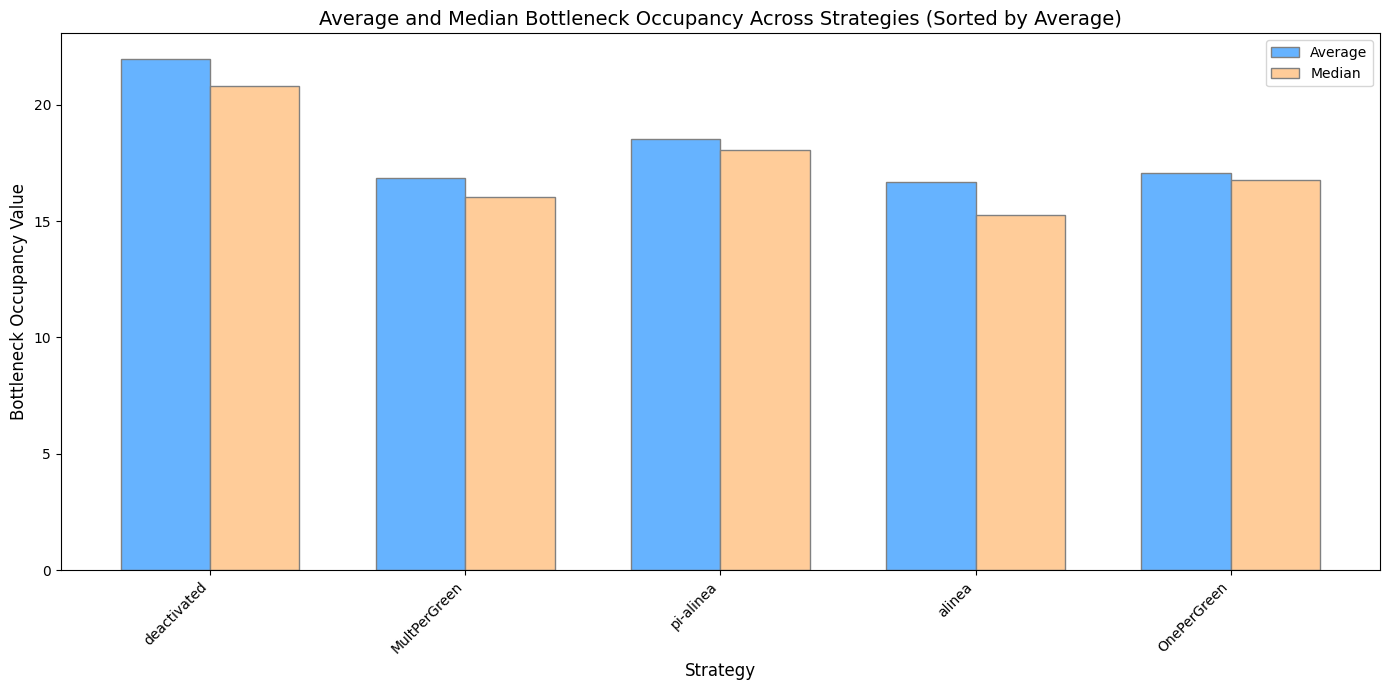

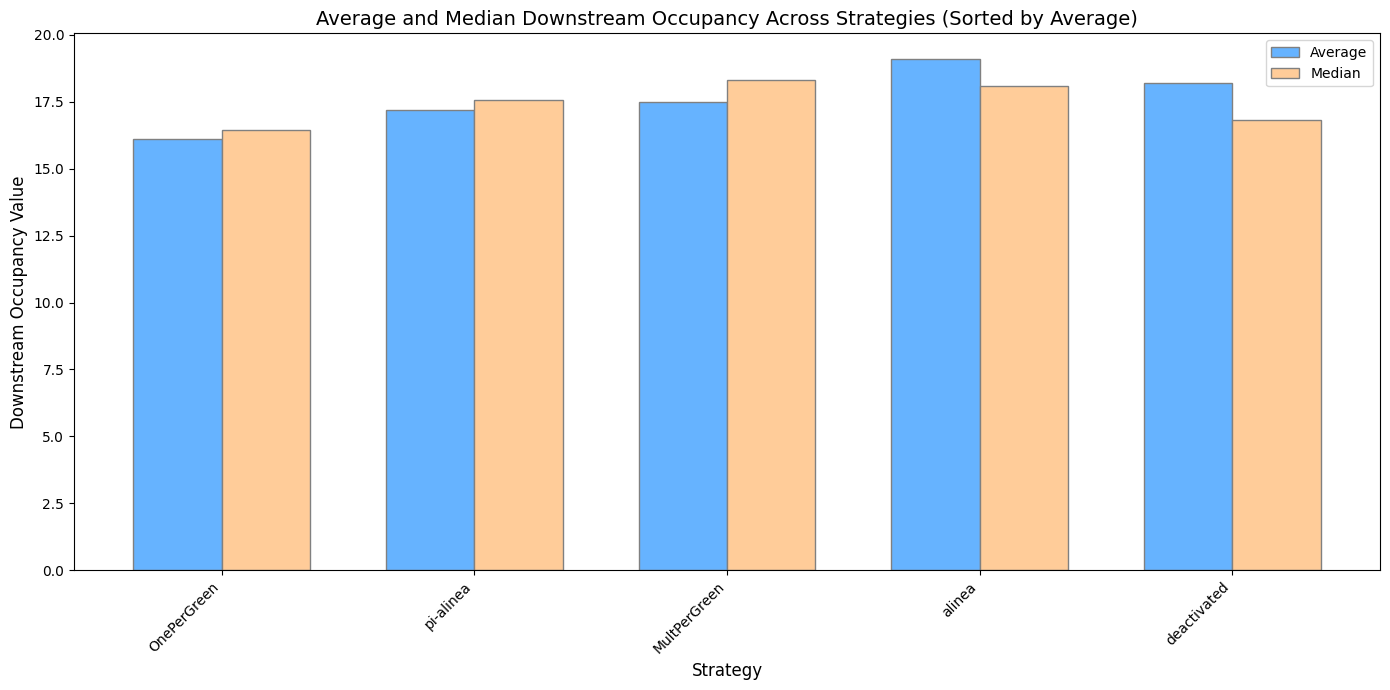

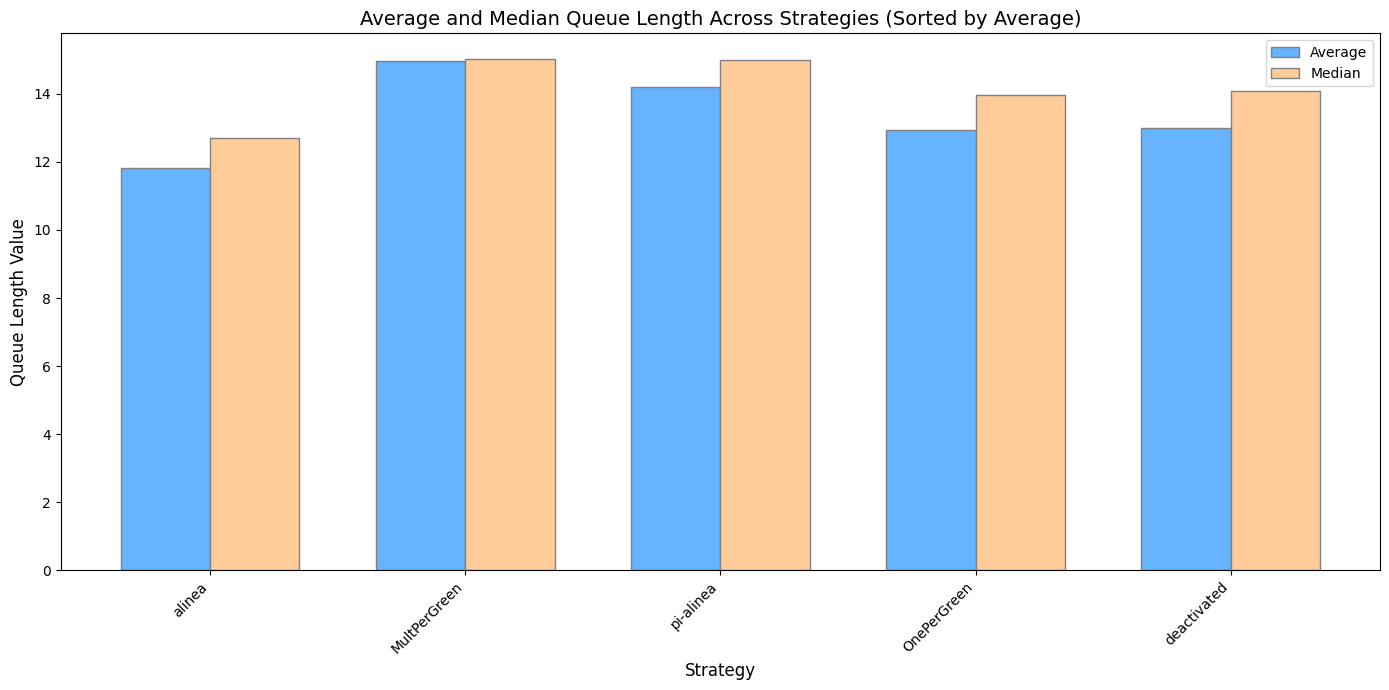

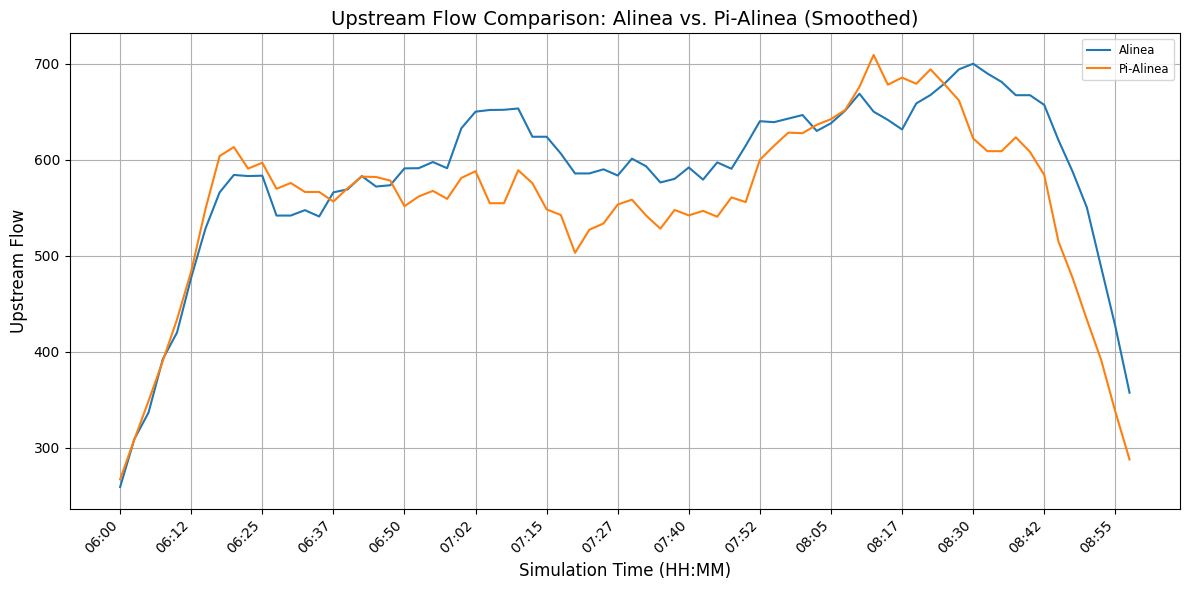

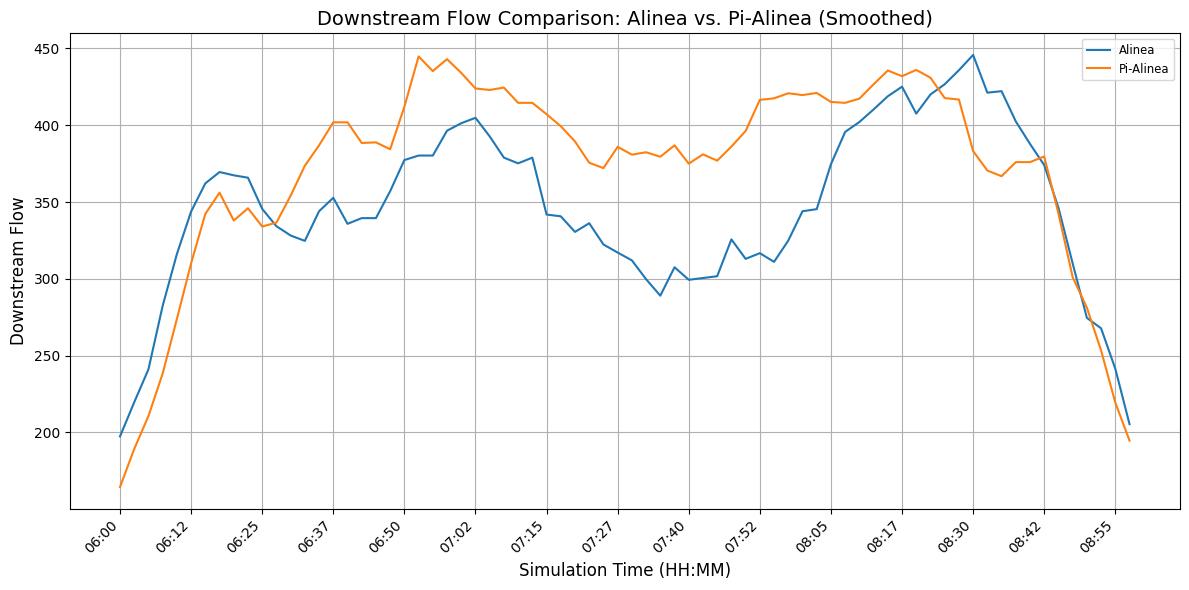

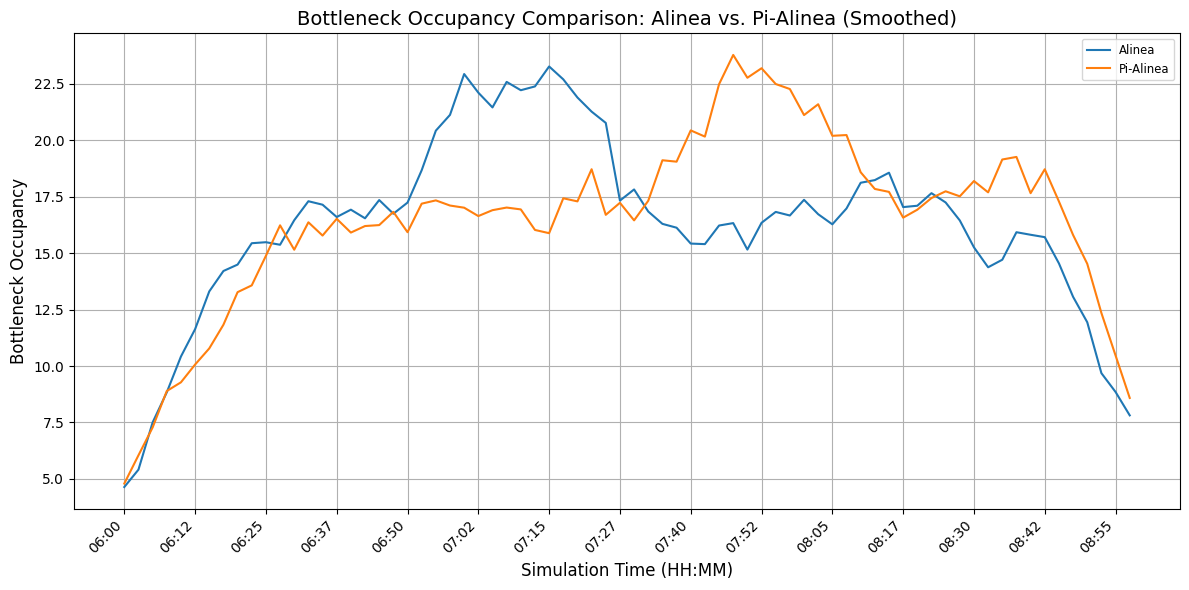

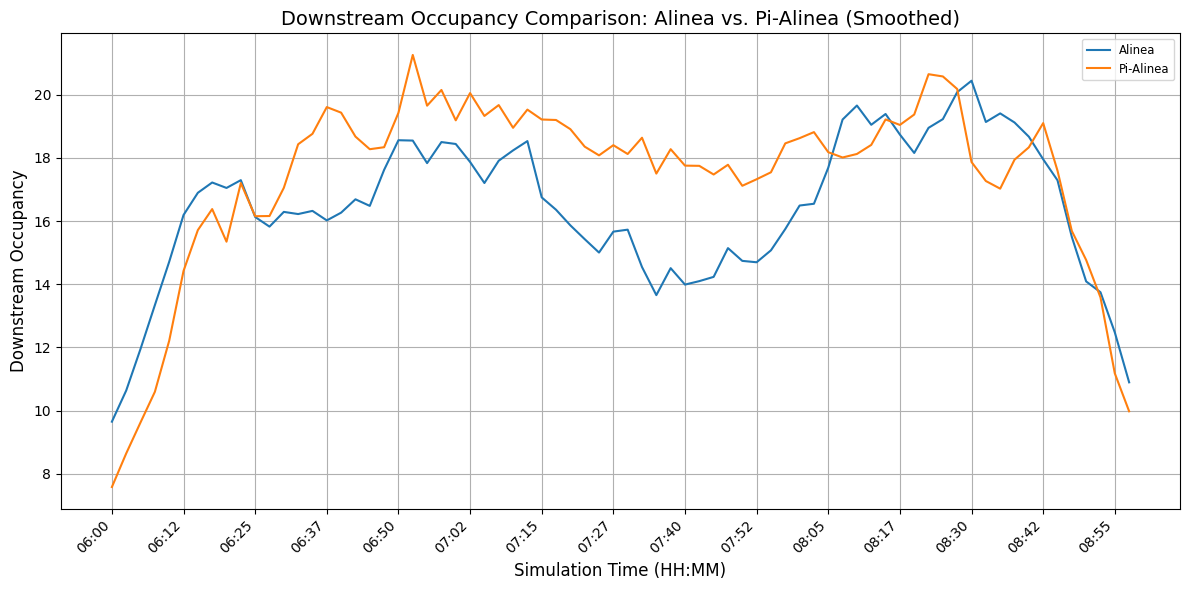

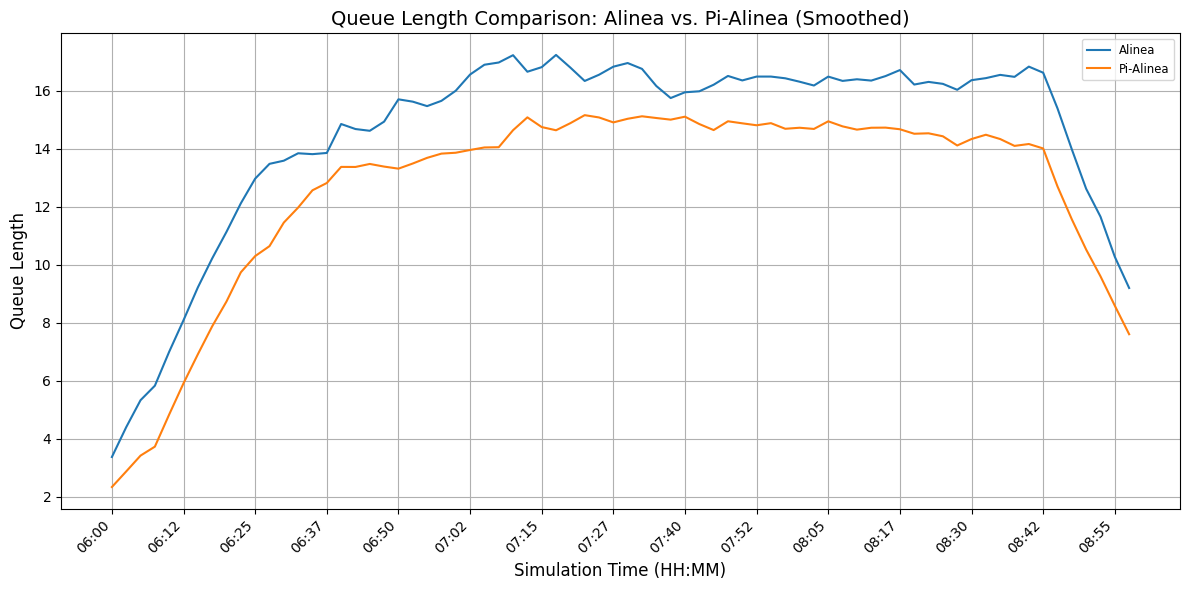

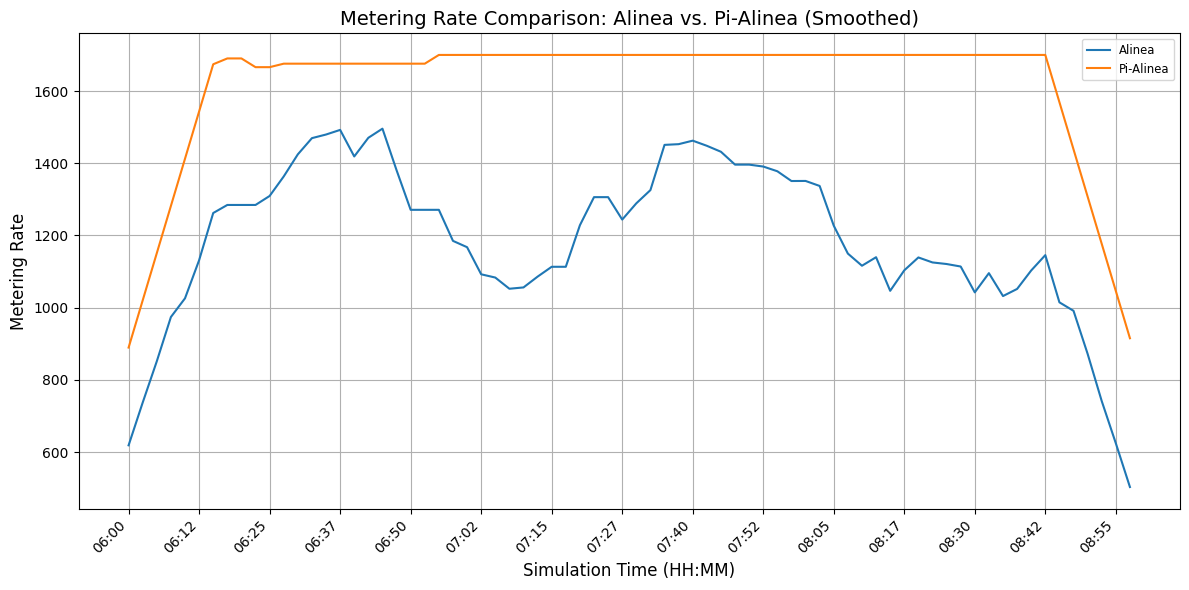

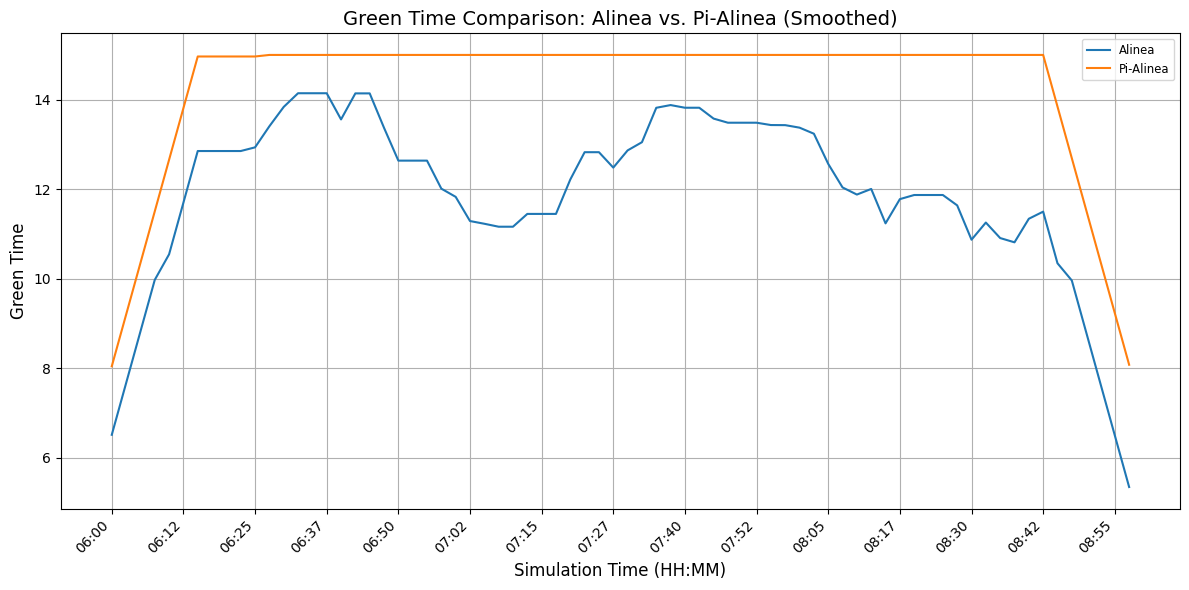

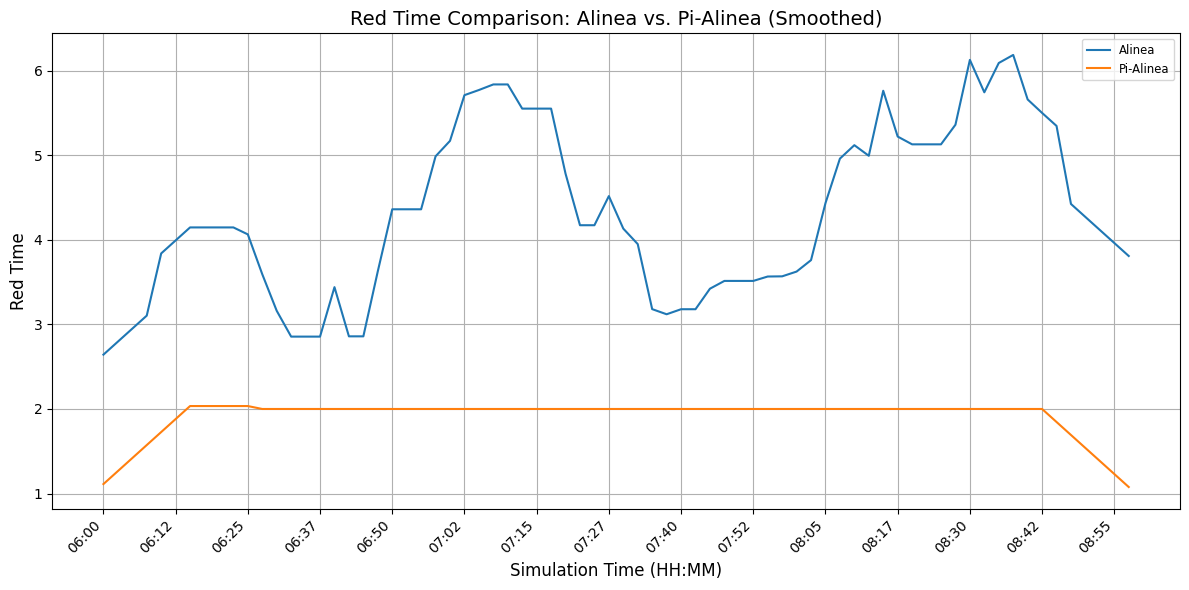

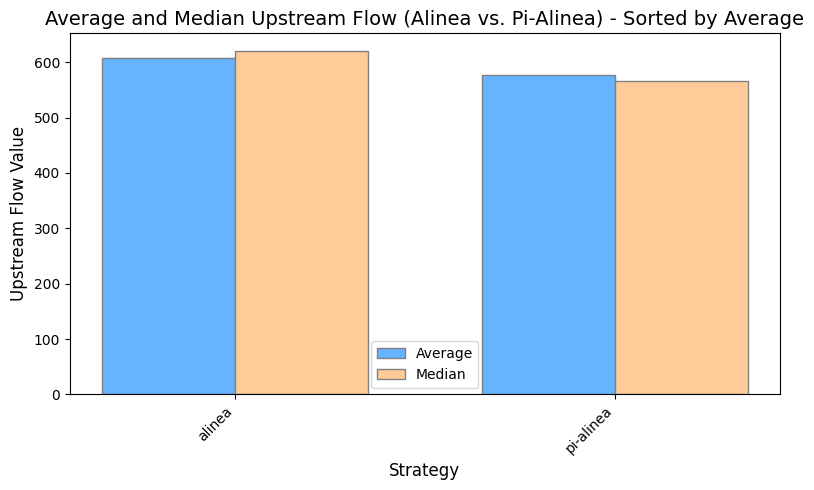

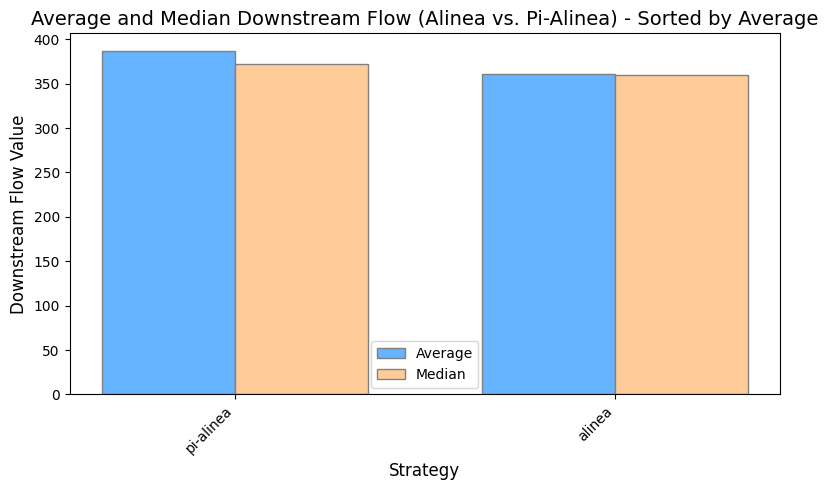

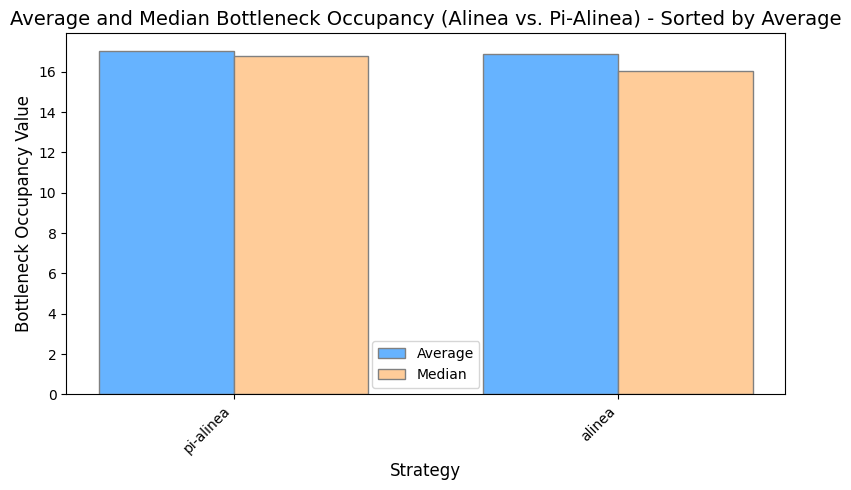

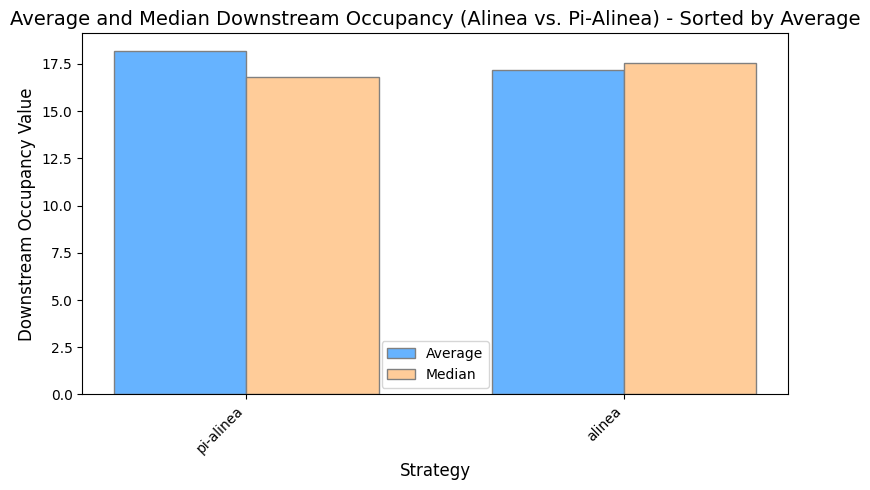

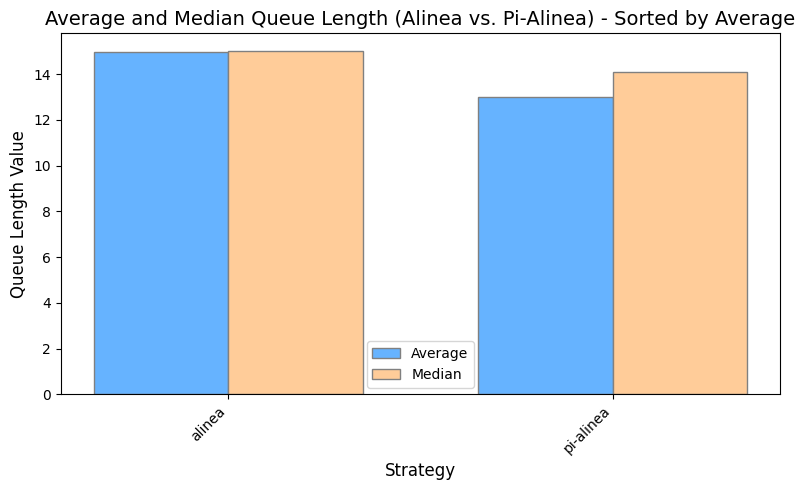

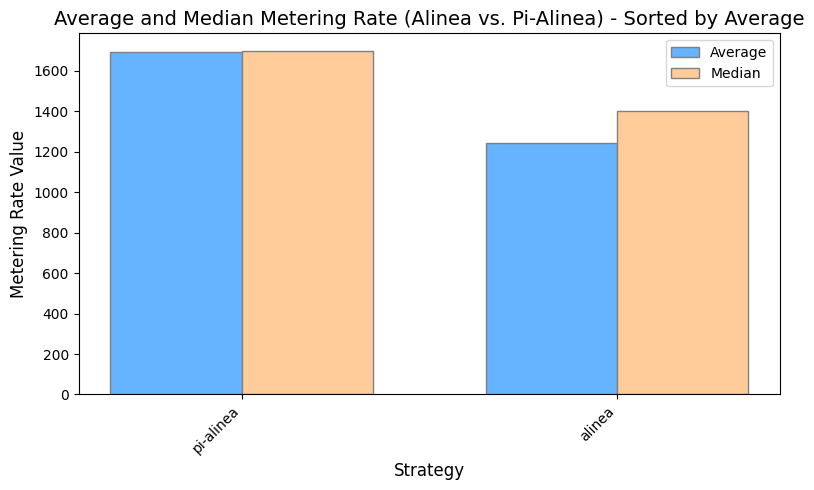

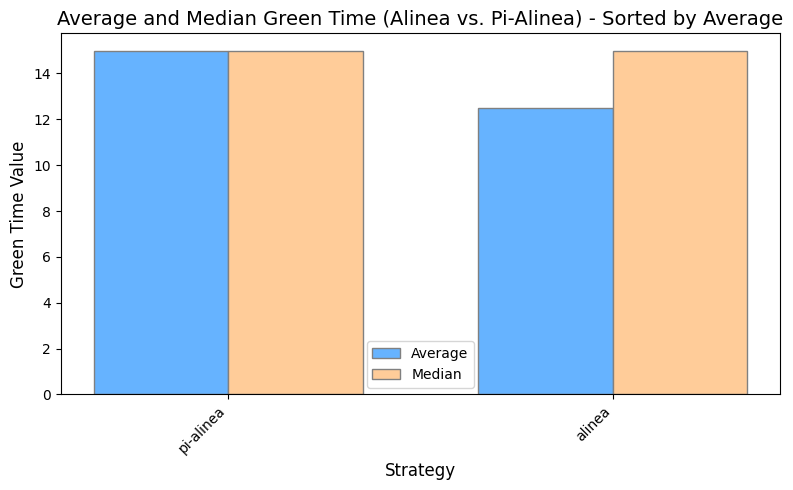

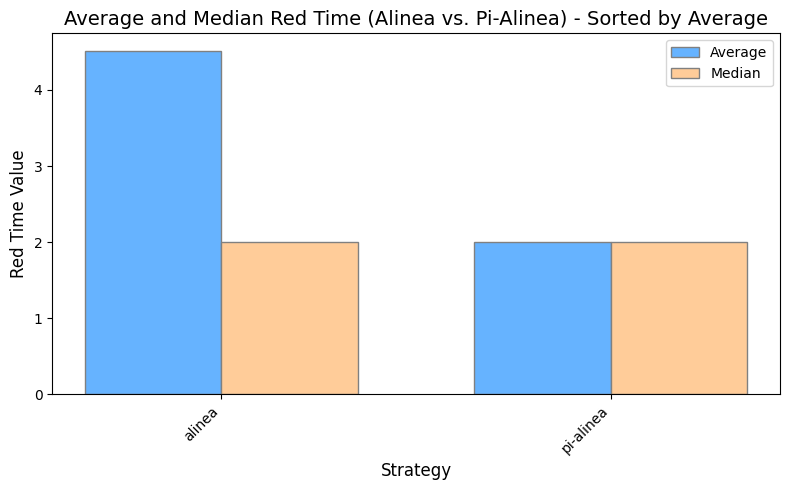

Average and Median Alinea vs Pi-Alinea plots generated successfully!
Plots generated successfully!


In [ ]:

def smooth_data(y, window_size):
    """Applies a moving average smoothing filter to the data."""
    if len(y) < window_size:
        return y  # Return original data if shorter than window
    window = np.ones(window_size) / window_size
    y_smoothed = np.convolve(y, window, mode='same')
    return y_smoothed


smoothing_window = 13 

for feature in features_all:
    plt.figure(figsize=(12, 6))
    plt.title(f'{feature} Comparison Across Strategies (Smoothed)', fontsize=14)
    plt.xlabel('Simulation Time (HH:MM)', fontsize=12)
    plt.ylabel(feature, fontsize=12)

    for strategy, df in data.items():
        if df is not None:
            # Interpolate the data to match all the steps
            x = df['Step']
            f = interp1d(x, df[feature], fill_value="extrapolate")
            y_interpolated = f(np.linspace(0, max_step, len(time_labels)))

            # Apply smoothing
            y_smoothed = smooth_data(y_interpolated, smoothing_window)

            plt.plot(time_labels, y_smoothed, label=strategy)

    plt.xticks(time_labels[::5], rotation=45, ha='right')  # Reduce x-axis label density
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{feature}_comparison_smoothed.png'))  # Save the smoothed plot in 'plots' folder
    plt.show()

# --- Calculate and Plot Average and Median (All Strategies in a Single Sorted Plot) ---

for feature in features_all:
    # Calculate Averages
    averages = {}
    for strategy, df in data.items():
        if df is not None:
            x = df['Step']
            f = interp1d(x, df[feature], fill_value="extrapolate")
            y_interpolated = f(np.linspace(0, max_step, len(time_labels)))
            averages[strategy] = np.mean(y_interpolated)

    # Calculate Medians
    medians = {}
    for strategy, df in data.items():
        if df is not None:
            x = df['Step']
            f = interp1d(x, df[feature], fill_value="extrapolate")
            y_interpolated = f(np.linspace(0, max_step, len(time_labels)))
            medians[strategy] = np.median(y_interpolated)


    # Sort by average value (descending)
    sorted_strategies = sorted(averages, key=averages.get, reverse=True)
    sorted_averages = {k: averages[k] for k in sorted_strategies}
    sorted_medians = {k: medians[k] for k in sorted_strategies}

    # Bar width
    bar_width = 0.35

    # Set positions of the bars on the x-axis
    r1 = np.arange(len(averages))
    r2 = [x + bar_width for x in r1]

    # Create the bar plot
    plt.figure(figsize=(14, 7))  # Increased figure size for better label visibility
    plt.bar(r1, averages.values(), color='#66b3ff', width=bar_width, edgecolor='grey', label='Average')  # Light blue
    plt.bar(r2, medians.values(), color='#ffcc99', width=bar_width, edgecolor='grey', label='Median')  # Light orange

    # Add labels, title, and custom x-axis tick labels
    plt.xlabel('Strategy', fontsize=12)
    plt.ylabel(f'{feature} Value', fontsize=12)
    plt.title(f'Average and Median {feature} Across Strategies (Sorted by Average)', fontsize=14)
    plt.xticks([r + bar_width/2 for r in range(len(averages))], sorted_strategies, rotation=45, ha='right') # Rotate labels
    plt.legend()

    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    plt.savefig(os.path.join(output_dir, f'average_median_{feature}_comparison_sorted.png'))
    plt.show()

# --- Comparative Plots for Alinea vs. Pi-Alinea ---
if data['alinea'] is not None and data['pi-alinea'] is not None:
    for feature in features_alinea:
        plt.figure(figsize=(12, 6))
        plt.title(f'{feature} Comparison: Alinea vs. Pi-Alinea (Smoothed)', fontsize=14)
        plt.xlabel('Simulation Time (HH:MM)', fontsize=12)
        plt.ylabel(feature, fontsize=12)

        # Interpolate and Smooth the data for Alinea
        x = data['alinea']['Step']
        f = interp1d(x, data['alinea'][feature], fill_value="extrapolate")
        y_interpolated_alinea = f(np.linspace(0, max_step, len(time_labels)))
        y_smoothed_alinea = smooth_data(y_interpolated_alinea, smoothing_window)  # Corrected line
        plt.plot(time_labels, y_smoothed_alinea, label='Alinea')

        # Interpolate and Smooth the data for Pi-Alinea
        x = data['pi-alinea']['Step']
        f = interp1d(x, data['pi-alinea'][feature], fill_value="extrapolate")
        y_interpolated_pialinea = f(np.linspace(0, max_step, len(time_labels)))
        y_smoothed_pialinea = smooth_data(y_interpolated_pialinea, smoothing_window)  # Corrected line
        plt.plot(time_labels, y_smoothed_pialinea, label='Pi-Alinea')

        plt.xticks(time_labels[::5], rotation=45, ha='right')
        plt.legend(loc='upper right', fontsize='small')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'{feature}_Alinea_vs_PiAlinea_smoothed.png'))
        plt.show()

if data['alinea'] is not None and data['pi-alinea'] is not None:
    for feature in features_alinea:
        # Calculate Averages
        averages = {}
        x = data['alinea']['Step']
        f = interp1d(x, data['alinea'][feature], fill_value="extrapolate")
        y_interpolated = f(np.linspace(0, max_step, len(time_labels)))
        averages['alinea'] = np.mean(y_interpolated)

        x = data['pi-alinea']['Step']
        f = interp1d(x, data['pi-alinea'][feature], fill_value="extrapolate")
        y_interpolated = f(np.linspace(0, max_step, len(time_labels)))
        averages['pi-alinea'] = np.mean(y_interpolated)

        # Calculate Medians
        medians = {}
        x = data['alinea']['Step']
        f = interp1d(x, data['alinea'][feature], fill_value="extrapolate")
        y_interpolated = f(np.linspace(0, max_step, len(time_labels)))
        medians['alinea'] = np.median(y_interpolated)

        x = data['pi-alinea']['Step']
        f = interp1d(x, data['pi-alinea'][feature], fill_value="extrapolate")
        y_interpolated = f(np.linspace(0, max_step, len(time_labels)))
        medians['pi-alinea'] = np.median(y_interpolated)

        # Sort by average value (descending)
        sorted_strategies = sorted(averages, key=averages.get, reverse=True)
        sorted_averages = {k: averages[k] for k in sorted_strategies}
        sorted_medians = {k: medians[k] for k in sorted_strategies}

        # Bar width
        bar_width = 0.35

        # Set positions of the bars on the x-axis
        r1 = np.arange(len(averages))
        r2 = [x + bar_width for x in r1]

        # Create the bar plot
        plt.figure(figsize=(8, 5))  # Increased figure size for better label visibility
        plt.bar(r1, sorted_averages.values(), color='#66b3ff', width=bar_width, edgecolor='grey', label='Average')  # Light blue
        plt.bar(r2, sorted_medians.values(), color='#ffcc99', width=bar_width, edgecolor='grey', label='Median')  # Light orange

        # Add labels, title, and custom x-axis tick labels
        plt.xlabel('Strategy', fontsize=12)
        plt.ylabel(f'{feature} Value', fontsize=12)
        plt.title(f'Average and Median {feature} (Alinea vs. Pi-Alinea) - Sorted by Average', fontsize=14)
        plt.xticks([r + bar_width/2 for r in range(len(averages))], sorted_strategies, rotation=45, ha='right') # Rotate labels
        plt.legend()

        plt.tight_layout()  # Adjust layout to prevent labels from overlapping
        plt.savefig(os.path.join(output_dir, f'average_median_{feature}_Alinea_vs_PiAlinea_sorted.png'))
        plt.show()

print("Average and Median Alinea vs Pi-Alinea plots generated successfully!")

print("Plots generated successfully!")